In [1]:
# pip install pathlib tensorflow

In [1]:
# imports
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
# import Augmentor

In [2]:
# Name of the image folder
imagePaths = '/Users/apple/Downloads/SDP/images'
trainImages = pd.read_csv('/Users/apple/Downloads/SDP/train.csv')

In [3]:
len(os.listdir('/Users/apple/Downloads/SDP/images/Mild')), len(os.listdir('/Users/apple/Downloads/SDP/images/Moderate')), len(os.listdir('/Users/apple/Downloads/SDP/images/No_DR')), len(os.listdir('/Users/apple/Downloads/SDP/images/Severe')), len(os.listdir('/Users/apple/Downloads/SDP/images/Proliferate_DR')),'3662'

(370, 999, 1805, 193, 295, '3662')

In [4]:
# p = Augmentor.Pipeline('/Users/apple/Downloads/SDP/images', output_directory='/Users/apple/Downloads/SDP/output')
# p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
# p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)
# p.sample(5000)

In [5]:
len(os.listdir('/Users/apple/Downloads/SDP/output/Mild')), len(os.listdir('/Users/apple/Downloads/SDP/output/Moderate')), len(os.listdir('/Users/apple/Downloads/SDP/output/No_DR')), len(os.listdir('/Users/apple/Downloads/SDP/output/Severe')), len(os.listdir('/Users/apple/Downloads/SDP/output/Proliferate_DR')),'5000'

(498, 1331, 2531, 259, 381, '5000')

In [6]:
import pathlib
data_dir = pathlib.Path('/Users/apple/Downloads/SDP/images')
img_height = 224
img_width = 224

In [7]:
import tensorflow as tf
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset='training', seed=123, image_size=(img_height, img_width), batch_size=32)

Found 3662 files belonging to 5 classes.
Using 2930 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset='validation', seed=123, image_size=(img_height, img_width), batch_size=32)

Found 3662 files belonging to 5 classes.
Using 732 files for validation.


In [9]:
train_ds, val_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [10]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y:(normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [12]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [14]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, Dropout

base_model = InceptionV3(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in base_model.layers[:10]:
	layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(5, activation='softmax')(x)
model1 = Model(inputs=base_model.inputs, outputs=predictions)

In [15]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
base_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
for layer in base_model.layers[:10]:
	layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(5, activation='softmax')(x)
model2 = Model(inputs=base_model.inputs, outputs=predictions)

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
model_filepath = '/Users/apple/Downloads/SDP/model/model-{epoch:02d}-{val_accuracy:.4f}.keras'
checkpoint = ModelCheckpoint(filepath=model_filepath, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

In [17]:
model1.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [18]:
model2.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [15]:
# pip install pyyaml h5py

In [19]:
history1 = model1.fit(train_ds, validation_data=val_ds, epochs=5, callbacks=[checkpoint])

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6407 - loss: 1.1318
Epoch 1: val_accuracy improved from -inf to 0.50410, saving model to /Users/apple/Downloads/SDP/model/model-01-0.5041.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 471s 5s/step - accuracy: 0.6413 - loss: 1.1295 - val_accuracy: 0.5041 - val_loss: 38.6092
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7328 - loss: 0.7919
Epoch 2: val_accuracy did not improve from 0.50410
92/92 ━━━━━━━━━━━━━━━━━━━━ 559s 6s/step - accuracy: 0.7328 - loss: 0.7916 - val_accuracy: 0.5041 - val_loss: 220.2269
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7692 - loss: 0.6821
Epoch 3: val_accuracy improved from 0.50410 to 0.67623, saving model to /Users/apple/Downloads/SDP/model/model-03-0.6762.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 526s 6s/step - accuracy: 0.7691 - loss: 0.6822 - val_accuracy: 0.6762 - val_loss: 1.4074
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7726 - loss: 0.6342
Epoch 4: val_accura

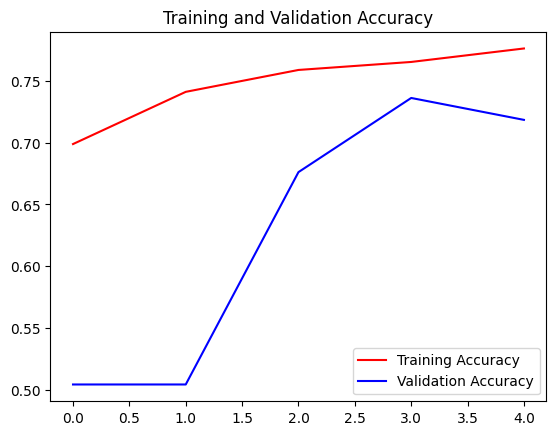

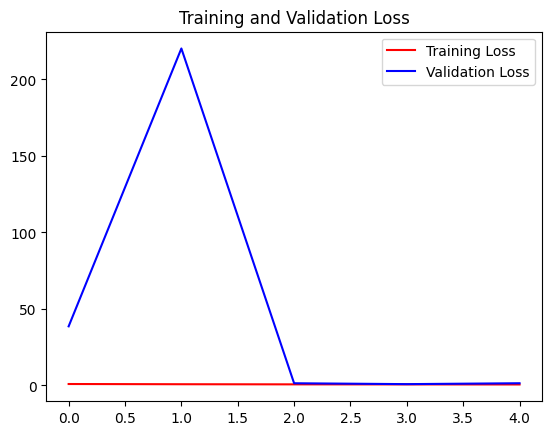

In [20]:
import matplotlib.pyplot as plt
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
# plt.figure()

plt.show()

In [21]:
history2 = model2.fit(train_ds, validation_data=val_ds, epochs=5, callbacks=[checkpoint])

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.4201 - loss: 8.8632 
Epoch 1: val_accuracy did not improve from 0.73634
92/92 ━━━━━━━━━━━━━━━━━━━━ 1267s 14s/step - accuracy: 0.4210 - loss: 8.8033 - val_accuracy: 0.6708 - val_loss: 0.9543
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.6929 - loss: 0.9392 
Epoch 2: val_accuracy did not improve from 0.73634
92/92 ━━━━━━━━━━━━━━━━━━━━ 1254s 14s/step - accuracy: 0.6929 - loss: 0.9387 - val_accuracy: 0.7090 - val_loss: 0.8401
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.6489 - loss: 1.1048 
Epoch 3: val_accuracy did not improve from 0.73634
92/92 ━━━━━━━━━━━━━━━━━━━━ 1288s 14s/step - accuracy: 0.6490 - loss: 1.1046 - val_accuracy: 0.7186 - val_loss: 0.8647
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.6946 - loss: 0.9309 
Epoch 4: val_accuracy did not improve from 0.73634
92/92 ━━━━━━━━━━━━━━━━━━━━ 1296s 14s/step - accuracy: 0.6948 - loss: 0.9303 - val_accuracy: 0.6790 - val_l

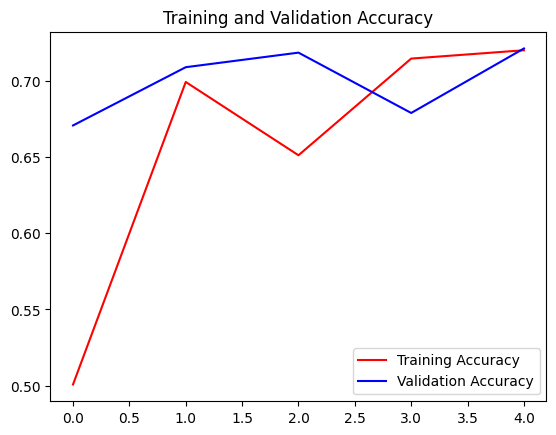

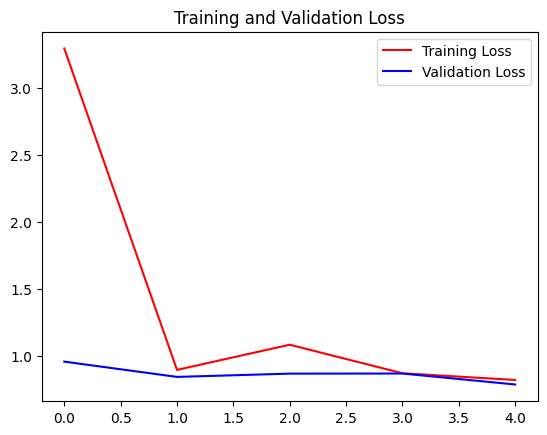

In [22]:
import matplotlib.pyplot as plt
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
# plt.figure()

plt.show()

In [23]:
from sklearn.ensemble import VotingRegressor

In [24]:
# !pip install sklearn

In [27]:
# from tf.keras.models import Model, load_model
# from tensorflow.keras.layers import Input, Average

# model_1 = load_model('/Users/apple/Downloads/SDP/model/model-03-0.6981.keras')
# model_1 = Model(inputs=model_1.inputs, outputs=model_1.outputs, name='name_of_model_1')

# model_2 = load_model('/Users/apple/Downloads/SDP/model/model-04-0.7077.keras')
# model_2 = Model(inputs=model_2.inputs, outputs=model_2.outputs, name='name_of_model_2')

# models = [model_1, model_2]
# model_input = Input(shape=(224, 224, 3))
# model_outputs = [model(model_input) for model in models]

# ensemble_output = Average()(model_outputs)
# ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

# from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.layers import Input, Average
# import numpy as np
# model_1 = load_model('/Users/apple/Downloads/SDP/model/model-03-0.7336.keras')
# model_1 = Model(inputs=model_1.inputs,
#                 outputs=model_1.outputs,
#                 name='name_of_model_1')
# model_2 = load_model('/Users/apple/Downloads/SDP/model/model-04-0.6680.keras')
# model_2 = Model(inputs=model_2.inputs,
#              outputs=model_2.outputs,
#               name='name_of_model_2')
# models = [model_1, model_2]

# weights = [0.7, 0.9]

# # w = np.array([0.7, 0.9])
# model_input = Input(shape=(224, 224, 3))
# model_outputs = [model(model_input) for model in models]

# # ensemble = VotingClassifier(estimators=models, weights=w, voting='soft')
# ensemble_output = Average()(model_outputs)
# ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

#=================================================================
# import numpy as np
# from tensorflow.keras.models import load_model, Model
# from tensorflow.keras.layers import Input, Average

# # Load the first model
# model_1 = load_model('/Users/apple/Downloads/SDP/model/model-03-0.7336.keras')
# model_1 = Model(inputs=model_1.inputs, outputs=model_1.outputs, name='name_of_model_1')

# # Load the second model
# model_2 = load_model('/Users/apple/Downloads/SDP/model/model-04-0.6680.keras')
# model_2 = Model(inputs=model_2.inputs, outputs=model_2.outputs, name='name_of_model_2')

# # Create a list of models
# models = [model_1, model_2]

# # Define weights for each model (adjust as needed)
# weights = [0.7, 0.9]

# # Define input shape for the ensemble model
# model_input = Input(shape=(224, 224, 3))

# # Generate predictions for each model
# model_outputs = [model(model_input) for model in models]

# # Average the predictions
# ensemble_output = Average()(model_outputs)

# # Create the ensemble model
# ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')


#=================================================================
# import numpy as np
# from tensorflow.keras.models import load_model, Model
# from tensorflow.keras.layers import Input, Average

# # Load the first model
# model_1 = load_model('/Users/apple/Downloads/SDP/model/model-03-0.7336.keras')
# model_1 = Model(inputs=model_1.inputs, outputs=model_1.outputs, name='name_of_model_1')

# # Load the second model
# model_2 = load_model('/Users/apple/Downloads/SDP/model/model-04-0.6680.keras')
# model_2 = Model(inputs=model_2.inputs, outputs=model_2.outputs, name='name_of_model_2')


# # Create a list of models
# models = [model_1, model_2]

# # Define input shape for the ensemble model
# model_input = Input(shape=(224, 224, 3))

# # Generate predictions for each model
# model_outputs = [model(model_input) for model in models]

# # Average the predictions
# ensemble_output = Average()(model_outputs)

# # Create the ensemble model
# ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')


#=================================================================

keras_model1 = tf.keras.models.load_model('/Users/apple/Downloads/SDP/model/model-03-0.6762.keras', compile=False) 
keras_model1._name = 'model1'
keras_model2 = tf.keras.models.load_model('/Users/apple/Downloads/SDP/model/model-04-0.7363.keras', compile=False) 
keras_model2._name = 'model2'

models = [keras_model1, keras_model2] 
#stacking individual models in a list
model_input = tf.keras.Input(shape=(224, 224, 3)) 
#takes a list of tensors as input, all of the same shape
model_outputs = [model(model_input) for model in models] 
#collects outputs of models in a list
ensemble_output = tf.keras.layers.Average()(model_outputs) 
#averaging outputs
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)
ensemble_model.summary()


ValueError: The name "functional_1" is used 2 times in the model. All operation names should be unique.

In [ ]:
ensemble_model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [ ]:
history = ensemble_model.fit(train_ds, validation_data=val_ds, epochs=5, callbacks=[checkpoint])

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
# plt.figure()

plt.show()

In [21]:
train_label = np.concatenate([y for x, y in train_ds], axis=0)
print(train_label.shape)

(2930,)


2024-05-12 13:18:06.933058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [22]:
test_label = np.concatenate([y for x, y in val_ds], axis=0)
print(test_label.shape)

(732,)


2024-05-12 13:18:06.947585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
pip install seaborn

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# from tensorflow import predict_generator

import matplotlib.pyplot as plt
Y_pred = ensemble_model.predict(val_ds, 1600)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_label, y_pred)
print(cm)
print('Classification Report')
target_names = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
print(classification_report(test_label, y_pred, target_names=target_names))


#=================================================================
# from sklearn.metrics import classification_report, confusion_matrix
# import numpy as np
# # Generate predictions using ensemble_model
# Y_pred = ensemble_model.predict(val_ds, steps=1600 // 224)
# y_pred = np.argmax(Y_pred, axis=1)

# # Print confusion matrix
# print('Confusion Matrix')
# cm = confusion_matrix(test_label, y_pred)
# print(cm)

# # Print classification report
# target_names = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
# print('Classification Report')
# print(classification_report(test_label, y_pred, target_names=target_names))


#=================================================================

# Assuming you have defined the batch size (batch_size) and the number of epochs (num_epochs)

# Calculate the total number of samples in the validation dataset
# num_val_samples = 5000  # Assuming 5000 samples

# # Calculate the number of steps for prediction
# steps = num_val_samples // batch_size

# # Make predictions
# Y_pred = ensemble_model.predict(val_ds, steps=steps)

# # Convert predictions to labels
# y_pred = np.argmax(Y_pred, axis=1)

# # Print confusion matrix
# print('Confusion Matrix')
# cm = confusion_matrix(test_label, y_pred)
# print(cm)

# # Print classification report
# target_names = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
# print('Classification Report')
# print(classification_report(test_label, y_pred, target_names=target_names))


23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step
Confusion Matrix
[[  0   0   0  76   0]
 [  0   0   0 193   0]
 [  0   0  78 291   0]
 [  0   0   0  58   0]
 [  0   0   0  36   0]]
Classification Report
                precision    recall  f1-score   support

          Mild       0.00      0.00      0.00        76
      Moderate       0.00      0.00      0.00       193
         No_DR       1.00      0.21      0.35       369
Proliferate_DR       0.09      1.00      0.16        58
        Severe       0.00      0.00      0.00        36

      accuracy                           0.19       732
     macro avg       0.22      0.24      0.10       732
  weighted avg       0.51      0.19      0.19       732



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

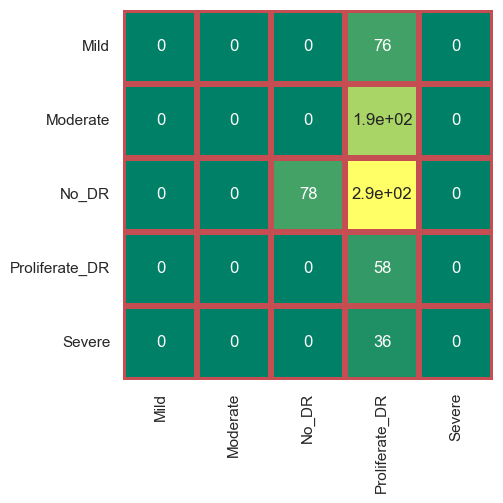

In [29]:
import seaborn as sns
sns.set(font_scale=1.0)
ax = sns.heatmap(cm, annot=True, cmap='summer', cbar=False,linewidth=3, linecolor='r', square=True, xticklabels=target_names, yticklabels=target_names)

In [30]:
sns.set(font_scale = 2.0)
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nActual Values')
ax.set_ylabel( 'Predicted Values ');